# GIS Analysis techniques 2: Final Project
## Childcare and Education Accessibility in Graz
#### Group 2: Conni S., Paul B., Elias P., Miriam E. 
---
#### 💡 Aim of the Project: evaluate the walking access to childcare facilities and schools and compare different cities’ family-friendliness

---
---

### Settings

In [61]:
# install necessary libraries
!pip install geopandas keplergl osmnx networkx shapely pandas numpy matplotlib rasterio rasterstats h3



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
# import necessary libraries
# Geospatial
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon, box, mapping
import h3
import rasterio
from rasterstats import zonal_stats

# Data handling
import pandas as pd
import numpy as np
import os
from pathlib import Path
from rasterio.mask import mask


# Visualization
import matplotlib.pyplot as plt
from keplergl import KeplerGl

#### Define the paths for the Grid & Population Data

In [63]:
# Relative paths (don't worry about this code - you can just run it as is)
project_root = Path.cwd()  
raw_dir = project_root / "Data" / "Raw"
processed_dir = project_root / "Data" / "Processed"
os.makedirs(processed_dir, exist_ok=True)

---

# Part A: Graz, Austria

## Part A.1: Data Preparation

#### Define and import Study Area

In [64]:
# define the study area place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change the crs to an Austrian metric CRS EPSG: 31256
target_crs = 31256
gdf_graz = gdf_graz.to_crs(epsg=target_crs)

In [65]:
# Get districts of Graz
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# Filter to only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=target_crs)

# Drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

👀 Inspect the Results of the Study Area

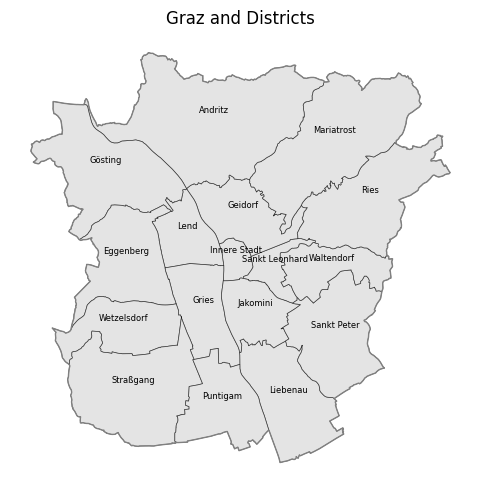

In [66]:
# Quick plot of Graz boundary and districts with labels
fig, ax = plt.subplots(figsize=(5, 5))
gdf_graz.boundary.plot(ax=ax, color='grey', linewidth=1)
gdf_districts.plot(ax=ax, color='lightgray', alpha=0.6, edgecolor='black', linewidth=0.5)

# Add district labels at centroids
gdf_districts['centroid'] = gdf_districts.geometry.centroid
for idx, row in gdf_districts.iterrows():
    ax.annotate(text=row['name'], xy=row['centroid'].coords[0], 
                xytext=(0, 5), textcoords='offset points', ha='center', fontsize=6)

ax.set_axis_off()
ax.set_title('Graz and Districts')
plt.tight_layout()
plt.show()


#### Get the OSM Data for Childcare facilities and schools

In [67]:
#define tags for childcare facilities and schools from OSMnx
tags = {
    "amenity": [
        "kindergarten",
        "childcare",
        "school"
    ]
}

# Download childcare facilities and schools within Graz boundary - 
# term "education" will be used here for childcare and education to simplify it 
gdf_education_orig = ox.features_from_place(place_name, tags=tags)

# Keep valid geometries and drop null geometries
gdf_education_orig = gdf_education_orig[gdf_education_orig.geometry.notnull()]

# Reproject to target CRS
gdf_education_orig = gdf_education_orig.to_crs(epsg=target_crs)

# convert all geometries to points
gdf_education_orig['geometry'] = gdf_education_orig.geometry.centroid

Check the OSMnx data wether we need to keep everything

In [68]:
# have a quick look at the OSMnx data
gdf_education_orig.head()

geometry       amenity  \
element id                                                       
node    117124121  POINT (-64531.412 212346.337)        school   
        270508838   POINT (-70741.166 215410.99)        school   
        270508839    POINT (-70722.31 215559.89)  kindergarten   
        270508846   POINT (-70563.47 217508.236)        school   
        280451771  POINT (-68282.012 214669.159)        school   

                                                           name addr:city  \
element id                                                                  
node    117124121                                 Waldorfschule       NaN   
        270508838                        Volksschule Algersdorf      Graz   
        270508839  Städtischer Kindergarten Algersdorfer Straße      Graz   
        270508846                                     HTL BULME      Graz   
        280451771               Johann Josef Fux Konservatorium       NaN   

                  addr:country addr:housenumber addr:postcode  \
element id                                                      
node    117124121          NaN              NaN           NaN   
        270508838           AT                9          8020   
        270508839           AT               15          8020   
        270508846           AT            15-21          8051   
        280451771          NaN              NaN           NaN   

                           addr:street     contact:phone isced:level  ...  \
element id                                                            ...   
node    117124121                  NaN               NaN         NaN  ...   
        270508838  Algersdorfer Straße  +43 316 872-6763           1  ...   
        270508839   Algersdorferstraße  +43 316 872 2601         NaN  ...   
        270508846         Ibererstraße               NaN         NaN  ...   
        280451771                  NaN               NaN         NaN  ...   

                  opening_date opening_hours:url building:material  \
element id                                                           
node    117124121          NaN               NaN               NaN   
        270508838          NaN               NaN               NaN   
        270508839          NaN               NaN               NaN   
        270508846          NaN               NaN               NaN   
        280451771          NaN               NaN               NaN   

                  addr2:housenumber addr2:street type building:part image  \
element id                                                                  
node    117124121               NaN          NaN  NaN           NaN   NaN   
        270508838               NaN          NaN  NaN           NaN   NaN   
        270508839               NaN          NaN  NaN           NaN   NaN   
        270508846               NaN          NaN  NaN           NaN   NaN   
        280451771               NaN          NaN  NaN           NaN   NaN   

                  loc_name tourism  
element id                          
node    117124121      NaN     NaN  
        270508838      NaN     NaN  
        270508839      NaN     NaN  
        270508846      NaN     NaN  
        280451771      NaN     NaN  

[5 rows x 88 columns]

Data Cleaning

In [69]:
# only keep columns 'amenity' and 'geometry'
cols_to_keep = ['amenity', 'geometry']
gdf_education = gdf_education_orig[cols_to_keep]
gdf_education.head()

amenity                       geometry
element id                                                    
node    117124121        school  POINT (-64531.412 212346.337)
        270508838        school   POINT (-70741.166 215410.99)
        270508839  kindergarten    POINT (-70722.31 215559.89)
        270508846        school   POINT (-70563.47 217508.236)
        280451771        school  POINT (-68282.012 214669.159)

👀 Have a closer look at the facilities with Kepler Map

In [70]:
# Create a KeplerGl map 
map_1 = KeplerGl(height=600)
# add facilities data
map_1.add_data(data=gdf_education, name="Childcare and Schools")
# display the map
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Childcare and Schools': {'index': [('node', 117124121), ('node', 270508838), ('node', 27050883…

#### Get the Walking Network

In [71]:
# Download walkable street network for Graz

# Custom filter to include bridges, footways, paths because using only "type=walk" filter misses these ways
custom_filter = '["highway"~"primary|secondary|tertiary|residential|unclassified|service|pedestrian|living_street|footway|path|steps|cycleway|track"]["bridge"!~"no"]["foot"!~"no"]'

# Download the walkable street network with custom filter
G_walk = ox.graph_from_place(
    place_name,
    network_type='walk',  # Base walk filter 
    custom_filter=custom_filter, #apply filter additionally
    retain_all=True,
    simplify=True
)

👀 Have a closer look at the network with Kepler Maps

In [72]:
# Visualize the walkable street network in Kepler 
map_2 = KeplerGl(height=600)
# add walkable street network data
map_2.add_data(data=ox.graph_to_gdfs(G_walk, nodes=False, edges=True), name="Walkable Street Network")
# display the map
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\miria\Documents\UNI\3_Semester\GIS_Analysetechniken\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'Walkable Street Network': {'index': [(20824406, 1450590079, 0), (20824406, 11535110095, 0), (2…

#### Create H3 Grid

In [73]:
# Create H3 hexagon grid for Graz

# First, convert Graz boundary to WGS84 (EPSG:4326) as H3 requires lat/lon coordinates
gdf_graz_wgs84 = gdf_graz.to_crs(epsg=4326)

# Get the boundary geometry
graz_boundary = gdf_graz_wgs84.geometry.iloc[0]

# H3 resolution 8 gives hexagons with average edge length of ~461m
# H3 resolution 9 gives hexagons with average edge length of ~174m
# We'll use resolution 8 for your 400-500m requirement
h3_resolution = 8

# Convert Shapely polygon to H3 LatLngPoly format
# Extract exterior coordinates and convert from (lon, lat) to (lat, lon)
exterior_coords = list(graz_boundary.exterior.coords)
outer_ring = [(lat, lon) for lon, lat in exterior_coords]

# Create H3 LatLngPoly object
h3_poly = h3.LatLngPoly(outer_ring)

# Get H3 hexagons that cover the Graz boundary
h3_hexagons = h3.h3shape_to_cells(h3_poly, h3_resolution)

print(f"Number of H3 hexagons covering Graz: {len(h3_hexagons)}")

# Convert H3 hexagons to polygons
hexagon_polygons_graz = []
hexagon_ids_graz = []

for hexagon in h3_hexagons:
    # Get the boundary of each hexagon as lat/lon coordinates
    hexagon_boundary = h3.cell_to_boundary(hexagon)
    # Create a Shapely polygon (convert from (lat, lon) to (lon, lat))
    hexagon_polygon = Polygon([(lon, lat) for lat, lon in hexagon_boundary])
    hexagon_polygons_graz.append(hexagon_polygon)
    hexagon_ids_graz.append(hexagon)

# Create a GeoDataFrame with the hexagons
gdf_hexagons_graz = gpd.GeoDataFrame(
    {'h3_id': hexagon_ids_graz},
    geometry=hexagon_polygons_graz,
    crs='EPSG:4326'
)

# Reproject to Austrian metric CRS
gdf_hexagons_graz = gdf_hexagons_graz.to_crs(epsg=target_crs)

# Add hexagon area in square meters
gdf_hexagons_graz['area_m2'] = gdf_hexagons_graz.geometry.area

# Add hexagon centroid for reference
gdf_hexagons_graz['centroid'] = gdf_hexagons_graz.geometry.centroid

print(f"\nHexagon grid statistics:")
print(f"Average hexagon area: {gdf_hexagons_graz['area_m2'].mean():.2f} m²")
print(f"Average hexagon 'diameter': {np.sqrt(gdf_hexagons_graz['area_m2'].mean() / 0.866):.2f} m")

# Display first few rows
gdf_hexagons_graz.head()

Number of H3 hexagons covering Graz: 177

Hexagon grid statistics:
Average hexagon area: 742928.03 m²
Average hexagon 'diameter': 926.22 m


,h3_id,geometry,area_m2,centroid
0,881e10a159fffff,"POLYGON ((-66439.547 220094.761, -66611.405 21...",742513.150679,POINT (-66074.325 219719.3)
1,881e10aa23fffff,"POLYGON ((-72757.771 210319.814, -72929.838 20...",743410.564451,POINT (-72392.563 209943.945)
2,881e10a117fffff,"POLYGON ((-64763.467 216338.315, -64935.322 21...",743020.099703,POINT (-64398.115 215962.671)
3,881e10aadbfffff,"POLYGON ((-64182.915 213707.498, -64354.78 213...",743351.467885,POINT (-63817.491 213331.73)
4,881e10b887fffff,"POLYGON ((-73593.102 217961.736, -73765.123 21...",742481.907524,POINT (-73228.073 217586.221)


👀 Let's have a quick look at the grid

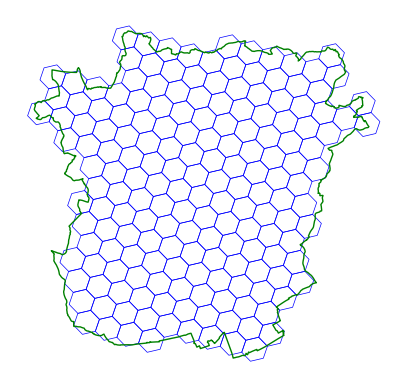

In [74]:
# Have a quick look at the hexagon grid as a plot
fig, ax = plt.subplots(figsize=(5, 5))
gdf_hexagons_graz.boundary.plot(ax=ax, color='blue', linewidth=
0.5)
gdf_graz.boundary.plot(ax=ax, color='green', linewidth=1)
ax.set_axis_off()
plt.show()


#### Population Data from the Global Human Settlement Layer

First, we will check the CRS again to be sure

In [75]:
# Step 1: Check CRS match
print("Step 1: CRS info")
print(f"Hexagons CRS: {gdf_hexagons_graz.crs}")
print(f"Hexagons count: {len(gdf_hexagons_graz)}")

Step 1: CRS info
Hexagons CRS: EPSG:31256
Hexagons count: 177


##### Import and aggregate the data
💡 The .tif file is rather large (cannot be saved on GitHub) and if saved locally, no one else could run the script top-to-bottom (unless downloading the data, saving it locally, changing paths, etc.). So this is why we work with an if-else function. If the raw .tif file can be found, then this will be used, and if it not (of course it cannot be found since it't too large), then the aggregated GeoParquet will be used. This is saved in the Data/Processed Order on GitHub and anyone can load it with this code without needing to download something or changing parts of the code.

In [76]:
# Define file paths
ghsl_file_graz = raw_dir / "GHS_POP_GRAZ_RAW.tif"
ghsl_pop_graz_path = processed_dir / "ghsl_pop_graz.parquet"

# Check if processed file already exists
if ghsl_pop_graz_path.exists():
    print("Processed file already exists. Loading existing data to preserve any modifications...")
    gdf_hexagons_graz = gpd.read_parquet(ghsl_pop_graz_path)
    print(f"Loaded pre-aggregated GHSL data from {ghsl_pop_graz_path}")
    print(f"Total population: {gdf_hexagons_graz['population'].sum():,.0f}")
    
elif ghsl_file_graz.exists():
    print("Processing GHSL population data for Graz (first time)...")
    pop_values = []
    
    with rasterio.open(ghsl_file_graz) as src:
        print(f"GHSL CRS: {src.crs}")
        print(f"GHSL bounds: {src.bounds}")
        
        # Reproject hexagons to match GHSL CRS
        hex_src_crs = gdf_hexagons_graz.to_crs(src.crs)
        
        for idx, hex_row in hex_src_crs.iterrows():
            try:
                # Zonal sum: total population per hexagon
                out_image, _ = mask(src, [hex_row.geometry], crop=True, nodata=0, filled=True)
                # Sum only positive values (population can't be negative)
                pop_sum = np.nansum(out_image[out_image > 0])
                pop_values.append(pop_sum if pop_sum > 0 else 0)
            except ValueError:
                # Hexagon outside raster bounds
                pop_values.append(0)
        
        print(f"Processed {len(pop_values)} hexagons")
    
    # Add population data to hexagons
    gdf_hexagons_graz['population'] = pop_values
    gdf_hexagons_graz['pop_density'] = gdf_hexagons_graz['population'] / gdf_hexagons_graz['area_m2']
    
    # Save aggregated data
    gdf_hexagons_graz.to_parquet(ghsl_pop_graz_path)
    print(f"Saved {len(gdf_hexagons_graz)} hexagons with population to {ghsl_pop_graz_path}")
    print(f"Total population: {gdf_hexagons_graz['population'].sum():,.0f}")
    
else:
    raise FileNotFoundError(f"Neither raw GHSL file nor processed data found!\n"
                          f"Raw file expected at: {ghsl_file_graz}\n"
                          f"Processed file expected at: {ghsl_pop_graz_path}")

# Display summary statistics
print("\nPopulation statistics per hexagon:")
print(gdf_hexagons_graz[['population', 'pop_density']].describe())

# Show top 10 hexagons by population
print("\nTop 10 hexagons by population:")
print(gdf_hexagons_graz.nlargest(10, 'population')[['h3_id', 'population', 'pop_density']])

Processed file already exists. Loading existing data to preserve any modifications...
Loaded pre-aggregated GHSL data from c:\Users\miria\Documents\UNI\3_Semester\GIS_Analysetechniken\GIS_FinalProject_Group2\Data\Processed\ghsl_pop_graz.parquet
Total population: 333,287

Population statistics per hexagon:
        population  pop_density
count   177.000000   177.000000
mean   1882.977528     0.002534
std    1940.252174     0.002611
min       0.000000     0.000000
25%     206.501989     0.000278
50%    1510.521323     0.002035
75%    2997.601563     0.004034
max    9616.629941     0.012942

Top 10 hexagons by population:
               h3_id   population  pop_density
26   881e10a121fffff  9616.629941     0.012942
105  881e10a123fffff  9303.767445     0.012520
119  881e10a107fffff  7304.253241     0.009832
13   881e10a13dfffff  7160.403779     0.009637
126  881e10a12dfffff  6693.606262     0.009009
51   881e10a12bfffff  6580.331978     0.008857
25   881e10a163fffff  6423.558174     0.0086

👀 Let's have a closer look at the population data using Kepler

In [79]:
# Visualize hexagon population data in KeplerGl
map_3 = KeplerGl(height=600)
map_3.add_data(data=gdf_hexagons_graz, name="Graz H3 Population")
map_3 

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Graz H3 Population': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, …

Let's check if the CRS are correct and the same!

In [87]:
print("gdf_hexagons_graz CRS:", gdf_hexagons_graz.crs)
print("target_crs:", target_crs)
print("Match?", gdf_hexagons_graz.crs == target_crs)


gdf_hexagons_graz CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "MGI / Austria GK East", "base_crs": {"name": "MGI", "datum": {"type": "GeodeticReferenceFrame", "name": "Militar-Geographische Institut", "ellipsoid": {"name": "Bessel 1841", "semi_major_axis": 6377397.155, "inverse_flattening": 299.1528128}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "id": {"authority": "EPSG", "code": 4312}}, "conversion": {"name": "Austria Gauss-Kruger East", "method": {"name": "Transverse Mercator", "id": {"authority": "EPSG", "code": 9807}}, "parameters": [{"name": "Latitude of natural origin", "value": 0, "unit": "degree", "id": {"authority": "EPSG", "code": 8801}}, {"name": "Longitude of natural origin", "value": 16.3333333333333, "unit": "d

#### Get Slope for more realistic walking time

## Part A.2: Accessibility Calculation

## Part A.3: Accessibility Indicator ("family-friendliness indicator")

---

# Part B: Uppsala, Sweden - _just an idea, because it's know for being very family friendly_

## Part B.1: Data Preparation

!!!ATTENTION: dont use place_name since it is used for graz --> change it!
generally, always put "uppsala" behind every df/gdf to not overwrite existing graz files. (e.g. the Graz Walk network is called G_walk -> make sure to use G_walk_uppsala or something similar!)

## Part B.2: Accesibility Calculation

## Part B.3: Accessibility Indicator ("family-friendliness indicator")

---

# Part C: Statistics, Visualisation & Mapping

## Part C.1: Graz

## Part C.2: Uppsala

## Part C.3: Comparison Maps